In [1]:
import os
import sys
sys.path.append('/lmh_data/work/SEE/train/')
sys.path.append('/lmh_data/work/SEE/analyse/')
import random

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.ticker import MultipleLocator

from util import array2mat, mat2array, mkdir

/root/miniconda3/envs/sclab/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gene_name = 'KAT8'
chrom, start, end = 'chr16', 31000000, 31240000
resolution = 10000

In [3]:
diff_hic = np.load('./tmp/Astro_{}_diffhic.npy'.format(gene_name), allow_pickle=True).item()

In [4]:
snps = pd.read_csv('KAT8_ccv.csv', sep=',')

_snps = snps[['RS_Number', 'Chrom', 'Coord_hg19', 'col', 'log10p']]
_snps.rename(columns={'RS_Number': 'name'}, inplace=True)
_snps.rename(columns={'Chrom': 'chrom'}, inplace=True)
_snps.rename(columns={'Coord_hg19': 'start'}, inplace=True)
_snps['chrom'] = 'chr' + _snps['chrom'].astype(str)
_snps['start'] = _snps['start'].astype(int)
_snps['end'] = _snps['start'] + 100
_snps = _snps.drop_duplicates(subset='name')
_snps

/tmp/ipykernel_303597/3822367203.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _snps.rename(columns={'RS_Number': 'name'}, inplace=True)
/tmp/ipykernel_303597/3822367203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _snps.rename(columns={'Chrom': 'chrom'}, inplace=True)
/tmp/ipykernel_303597/3822367203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _snps.rename(columns={'Coord_hg19': 'start'}, inplace=True)
/tmp/ipyker

,name,chrom,start,col,log10p,end
0,rs1060506,chr16,31133449,red,8.207138,31133549
1,rs11865499,chr16,31132250,purple,8.281263,31132350
2,rs28725459,chr16,31132662,red,8.199924,31132762
3,rs59735493,chr16,31133100,red,8.219968,31133200
4,rs60996860,chr16,31134213,red,8.318142,31134313
...,...,...,...,...,...,...
266,rs751117,chr16,31094918,grey,0.382516,31095018
267,rs75192677,chr16,31029196,grey,0.144676,31029296
268,rs75845939,chr16,31035630,grey,0.407859,31035730
269,rs889546,chr16,31153780,grey,0.257213,31153880


In [5]:
def plot_SNP(ax, df, chrom, start, end, line=1, gene_col=[], fontszie=5):
    df = df[df['chrom']==chrom]
    df_plot = df[((df['start'] >= start) & (df['start'] <= end))]
    df_plot = df_plot.sort_values(by='start')
    line = max(line, df_plot.shape[0])
    
    plot_num = df_plot.shape[0]

    for i,row in df_plot.iterrows():
        ax.bar(x=row['start'], height=100, width=50, bottom=0, \
               color=row['col'], ecolor=None)
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
#     if plot_num < line:
#         ax.spines['bottom'].set_position(('data', plot_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [6]:
v19_anno = pd.read_csv('/lmh_data/data/sclab/public/gencode.v19.annotation.gtf',
                       header=None, sep='\t', skiprows=[i for i in range(5)], usecols=[0, 2, 3, 4, 6, 8], names=[
                           'chrom', 'type', 'start', 'end', 'strand', 'info'
                       ])
v19_anno['gene_name'] = v19_anno['info'].str.extract(r'(gene_name ")(\S*)(")')[1]
v19_anno['transcript_name'] = v19_anno['info'].str.extract(r'(transcript_name ")(\S*)(")')[1]
v19_anno

,chrom,type,start,end,strand,info,gene_name,transcript_name
0,chr1,gene,11869,14412,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1
1,chr1,transcript,11869,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
2,chr1,exon,11869,12227,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
3,chr1,exon,12613,12721,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
4,chr1,exon,13221,14409,+,"gene_id ""ENSG00000223972.4""; transcript_id ""EN...",DDX11L1,DDX11L1-002
...,...,...,...,...,...,...,...,...
2619439,chrM,transcript,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619440,chrM,exon,15888,15953,+,"gene_id ""ENSG00000210195.2""; transcript_id ""EN...",MT-TT,MT-TT-201
2619441,chrM,gene,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP
2619442,chrM,transcript,15956,16023,-,"gene_id ""ENSG00000210196.2""; transcript_id ""EN...",MT-TP,MT-TP-201


In [7]:
transcript_info = v19_anno[v19_anno['type']=='transcript'].copy()
transcript_info = transcript_info.set_index('transcript_name')
transcript_info = transcript_info.drop(labels='info', axis=1)
transcript_info = transcript_info.drop(labels='type', axis=1)

exons = v19_anno[(v19_anno['type']=='exon')&(v19_anno['transcript_name'].isin(transcript_info.index))].copy()
exons['blockSizes'] = exons['end'] - exons['start']
exons['blockStarts'] = exons['start']
exons_group = exons.groupby("transcript_name")
transcript_info['blockCount'] = exons_group['blockStarts'].count()
transcript_info['blockSizes'] = exons_group['blockSizes'].apply(list)
transcript_info['blockStarts'] = exons_group['blockStarts'].apply(list)
transcript_info

,chrom,start,end,strand,gene_name,blockCount,blockSizes,blockStarts
transcript_name,,,,,,,,
DDX11L1-002,chr1,11869,14409,+,DDX11L1,3,"[358, 108, 1188]","[11869, 12613, 13221]"
DDX11L1-201,chr1,11872,14412,+,DDX11L1,3,"[355, 108, 1187]","[11872, 12613, 13225]"
DDX11L1-202,chr1,11874,14409,+,DDX11L1,4,"[353, 126, 252, 748]","[11874, 12595, 13403, 13661]"
DDX11L1-001,chr1,12010,13670,+,DDX11L1,6,"[47, 48, 84, 77, 153, 217]","[12010, 12179, 12613, 12975, 13221, 13453]"
WASH7P-202,chr1,14363,29370,-,WASH7P,12,"[49, 153, 111, 146, 140, 131, 201, 158, 43, 10...","[29321, 24738, 18268, 17915, 17602, 17233, 168..."
...,...,...,...,...,...,...,...,...
MT-ND6-201,chrM,14149,14673,-,MT-ND6,1,[524],[14149]
MT-TE-201,chrM,14674,14742,-,MT-TE,1,[68],[14674]
MT-CYB-201,chrM,14747,15887,+,MT-CYB,1,[1140],[14747]


In [8]:
def plot_gene(ax, gene_bed, chrom, start, end, line=1, gene_col=[], fontszie=5):
    gene_bed = gene_bed[gene_bed['chrom']==chrom]
    gene_bed_plot = gene_bed[((gene_bed['start'] >= start) & (gene_bed['start'] <= end)) | ((gene_bed['end'] >= start) & (gene_bed['end'] <= end))]
    gene_bed_plot = gene_bed_plot.sort_values(by='end')
    gene_bed_plot = gene_bed_plot.groupby('gene_name').agg(
        {'start': 'min', 'end': 'max', 'chrom': 'first', 'strand': 'first'}
    ).reset_index()
    line = max(line, gene_bed_plot.shape[0])
    
    plot_gene_num = gene_bed_plot.shape[0]
    if line == 1:
        for i,row in gene_bed_plot.iterrows():
            ax.plot((row['start'], row['end']), (0.5, 0.5), color='b')
            
            ax.bar(x=[row['start'], row['end']], height=1, width=3, bottom=0, \
                   edgecolor='black', linewidth=0, align='edge', color='b', ecolor=None)
    else:
        ii = 0
        for i,row in gene_bed_plot.iterrows():
            col = "#3366CC"
            text_col = '#3366CC'
            
            if row["strand"] == "-":
                col = "#EECFA1"
                text_col = '#EECFA1'
            
            #text_col = col
            plot_y = ii%line
            
            if i in gene_col:
                col = "red"
                text_col = "red"
            
            ax.plot((row['start'], row['end']), (plot_y + 0.5, plot_y+0.5), color=col)
            
            ax.bar(x=[row['start'], row['end']], height=0.8, width=3, bottom=plot_y+0.1, \
                   edgecolor=col, linewidth=0.3, align='edge', color=col)
            
            if row['start'] < start:
                    row['start'] = start
            if row['end'] > end:
                    row['end'] = end
            
            ax.text(row['start'], plot_y + 0.5, row['gene_name'] + "  ", ha='right', va='center',color=text_col, fontsize=fontszie)

            ii+=1
            
    ax.set_xlim(start,end)
    ax.set_ylim(top=0, bottom=line)
    if plot_gene_num < line:
        ax.spines['bottom'].set_position(('data', plot_gene_num))
    
    for i in ['left','top','right']:
        ax.spines[i].set_color('none')
        ax.spines[i].set_linewidth(0)
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(0.5)
    ax.tick_params(bottom =True,top=False,left=False,right=False)
    #ax.set_xticklabels("")
    ax.set_yticklabels("")

In [9]:
import pyBigWig

ATAC_ASC_Control = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_Control_hg19.bw')
H3K4me3_Control = pyBigWig.open('/lmh_data/data/sclab/source/prefrontal_cortex/ENCFF338YMX.hg19.bw')
H3K27ac_Control = pyBigWig.open('/lmh_data/data/sclab/source/prefrontal_cortex/ENCFF298WAS.hg19.bw')
H3K27me3_Control = pyBigWig.open('/lmh_data/data/sclab/source/prefrontal_cortex/ENCFF689GBH.hg19.bw')

ATAC_ASC_AD = pyBigWig.open('/lmh_data/data/sclab/syn22092838/ASC_AD_hg19.bw')
H3K4me3_AD = pyBigWig.open('/lmh_data/data/sclab/source/AD/ENCFF021IPQ.hg19.bw')
H3K27ac_AD = pyBigWig.open('/lmh_data/data/sclab/source/AD/ENCFF291ODB.hg19.bw')
H3K27me3_AD = pyBigWig.open('/lmh_data/data/sclab/source/AD/ENCFF946BPV.hg19.bw')

In [10]:
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [11]:
predict_hic = np.load('./tmp/Astro_{}_predict_hic.npy'.format(gene_name), allow_pickle=True).item()
for key in predict_hic:
    predict_hic[key] = array2mat(predict_hic[key])
delta_hic = predict_hic['AD_hic'] - predict_hic['control_hic']

delta_hic = (delta_hic / max(delta_hic.max(), abs(delta_hic.min())))
predict_hic['AD_hic'] = (predict_hic['AD_hic'] / predict_hic['AD_hic'].max())
predict_hic['control_hic'] = (predict_hic['control_hic'] / predict_hic['control_hic'].max())

In [12]:
def get_interactions(indices, score_matrix):
    row_indices, col_indices = indices[0], indices[1]
    _interactions = set()
    for i in range(row_indices.shape[0]):
        _bin1, _bin2 = row_indices[i]*resolution+start+resolution/2, col_indices[i]*resolution+start+resolution/2
        if _bin1 == _bin2:
            continue
        if (_bin2, _bin1, score_matrix[row_indices[i], col_indices[i]]) in _interactions:
            continue
        _interactions.add((_bin1, _bin2, score_matrix[row_indices[i], col_indices[i]]))
    return pd.DataFrame(_interactions, columns=['pos1', 'pos2', 'score'])

def two_degree_bc(x_l=10, x_r=90, y_lr=0, y2=10, dots_num=100): #bezier curve
    xt = []
    yt = []
    x_mid = (x_l + x_r)/2
    x_dots12 = np.linspace(x_l, x_mid, dots_num)
    y_dots12 = np.linspace(y_lr, y2, dots_num)
    x_dots23 = np.linspace(x_mid, x_r, dots_num)
    y_dots23 = np.linspace(y2, y_lr, dots_num)
    for i in range(dots_num):
        x = x_dots12[i] + (x_dots23[i]-x_dots12[i])*i / (dots_num-1)
        y = y_dots12[i] + (y_dots23[i]-y_dots12[i])*i / (dots_num-1)
        xt.append(x)
        yt.append(y)
    return (xt, yt)

def plot_predict_loop(ax, ylabel, df, start: int, end: int, cmap_name: str = 'magma'):
    loops = df.copy()
    lengths = abs(loops["pos2"] - loops["pos1"])

    loops = loops[(loops['pos1']>start)&(loops['pos1']<end)&(loops['pos2']>start)&(loops['pos2']<end)]
    loops = loops.apply(lambda x: (x['pos1'], x['pos2'], x['score']), axis=1).values.tolist()

    if len(loops) == 0:
        for i in ['top', 'right', "left", "bottom"]:
            ax.spines[i].set_color('none')
            ax.spines[i].set_linewidth(0)
        return

    _cm = plt.cm.get_cmap(cmap_name)
    top_y = 0
    for loop, length in zip(loops, lengths):
        top = length / max(lengths)
        top = max(0.5, top)
        top = min(0.8, top)
        
        xt, yt = two_degree_bc(x_l=loop[0], x_r=loop[1], y_lr=0, y2=top, dots_num=100)

        ax.plot(xt, yt, color=_cm(loop[2]))
        if max(yt) > top_y:
            top_y = max(yt)

    ax.set_xlim(start,end)
    ax.set_ylim(0,0.5)
    ax.set_ylabel(ylabel, fontsize=8, rotation=0, horizontalalignment='right', verticalalignment='center')
    for i in ['top', 'right']:
        ax.spines[i].set_color('none')
        #ax.spines[i].set_linewidth(0.5)
        
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)  
    
    
    ax.tick_params(bottom =False,top=False,left=False,right=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [13]:
def pre_track(title=None):
    fig = plt.figure(figsize=(20, 13), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(19, 1)
    ax0 = fig.add_subplot(gs[0:2, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[2:7, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[7, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax4 = fig.add_subplot(gs[9, 0], facecolor='white')
    ax5 = fig.add_subplot(gs[10, 0], facecolor='white')
    ax6 = fig.add_subplot(gs[11, 0], facecolor='white')
    ax7 = fig.add_subplot(gs[12, 0], facecolor='white')
    ax8 = fig.add_subplot(gs[13, 0], facecolor='white')
    ax9 = fig.add_subplot(gs[14, 0], facecolor='white')
    ax10 = fig.add_subplot(gs[15:17, 0], facecolor='white')
    ax11 = fig.add_subplot(gs[17:19, 0], facecolor='white')

    
    plot_SNP(ax0, _snps, chrom, start, end, line=2, gene_col=[], fontszie=6)
    
    plot_gene(ax1, transcript_info, chrom, start, end, line=10, gene_col=[], fontszie=8)
    
    plot_bwTrack(ax2, ATAC_ASC_Control, "ATAC(Astro&Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax3, H3K4me3_Control, "H3K4me3(Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax4, H3K27ac_Control, "H3K27ac(Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax5, H3K27me3_Control, "H3K27me3(Control)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')

    plot_bwTrack(ax6, ATAC_ASC_AD, "ATAC(Astro&AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax7, H3K4me3_AD, "H3K4me3(AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax8, H3K27ac_AD, "H3K27ac(AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    plot_bwTrack(ax9, H3K27me3_AD, "H3K27me3(AD)", chrom, start, end, resolution=100,
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')

    indices = np.where(
        (
            (predict_hic['control_hic'] >= np.percentile(predict_hic['control_hic'], 90)) | 
            (predict_hic['AD_hic'] >= np.percentile(predict_hic['AD_hic'], 90))
        )
    )
    plot_predict_loop(
        ax10, 'SEE',
        get_interactions(indices, diff_hic['diff_hic']/0.02), start, end
    )
    
    plot_predict_loop(
        ax11, 'SEE',
        get_interactions(indices, delta_hic/2+0.5), start, end, 'RdBu_r'
    )
    
    if title:
        plt.savefig(os.path.join('/lmh_data/work/SEE/analyse/figure_file/', title), format='pdf', bbox_inches='tight')
    plt.show()

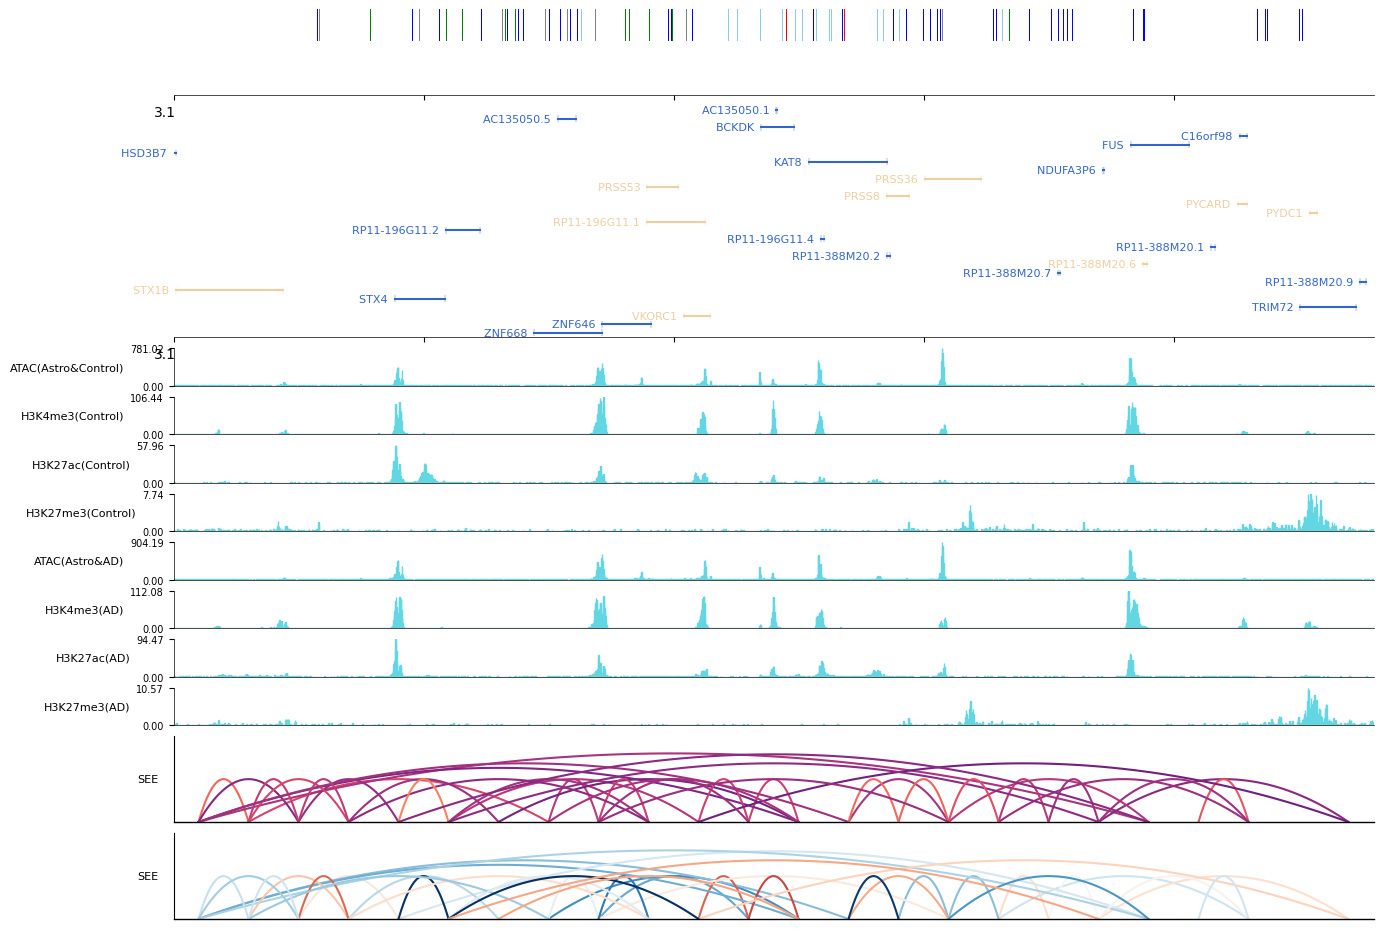

In [14]:
pre_track('Alzheimer/KAT8.pdf')